### A series of attempts to answer Google-able questions with the power of python. 
I. Does popcorn popping follow a normal distribution?

In [3]:
#!/usr/bin/env python
import sys
from pylab import *
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [4]:
# Sample width: 
#  Number of bytes required to represent value on storage medium.  This 
#  is a vertical quantity (eg ADCs); frame rate gives us horizontal (TDCs)
# Number of frames: 
#  Number of samples. For the example file, 
#  > 821659 samples / 44100 (samples/s) 
#  > 18.631723356009072 s
# => 1. / 44100 (samples/s) = 2.268E-5 s / sample

In [5]:
file_wav = 'Popcorn.wav' 

wf = wave.open(file_wav,'r')
wf_frames = wf.readframes(-1) #wf.getnframes())
wf_frames = fromstring(wf_frames, 'Int16')
nchannels = wf.getnchannels()

#I recorded with 2 channels--extract info for just one
data_per_channel = [wf_frames[offset] for offset in xrange(0,len(wf_frames),nchannels)]

In [6]:
def peak_finder(times,wav,thresh):
    """
    Here we scan the waveform for peaks (which indicate presence of a pop)
    Are we in a peak? If so, find + store max amp and corresponding time
    """
    peak_t_v = [] 
    max_amp_v = []
    in_peak = False
    start_t = 0
    max_amp = -1.
    max_time = -1.
    for i in xrange(len(wav)):
       
        if wav[i] > thresh :
            in_peak = True
            
            if wav[i] > max_amp:
                max_amp = wav[i]
                max_time = times[i]
       
        if wav[i] < thresh and in_peak:
            in_peak = False
            peak_t_v.append(max_time)
            max_amp_v.append(max_amp)
            max_amp = -1
            max_time = -1
                
    return peak_t_v

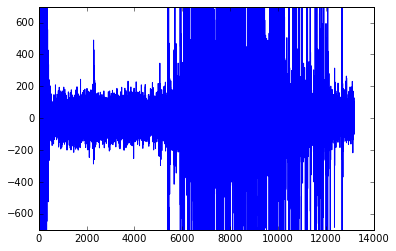

In [7]:
# Recall 44100 samp/s, 2e-5 s/samp
# This is way more samples than we'll need
# For now, let's down sample from [44100 -> 100] samp/s
ds_rate     = 100 
record_time = len(data_per_channel) / wf.getframerate() # 132 s
new_samples = len(data_per_channel) / (record_time * ds_rate ) # 442 samples in new set

# Build new time vector based on new sampling rate
time_v = [  float("{0:.2f}".format(t* (1./ds_rate) )) for t in xrange(record_time * ds_rate)]

# Build new sample vector; second line accounts for floating point chop
down_sampled_v = [data_per_channel[i] for i in xrange(0,len(data_per_channel),new_samples)]
down_sampled_v = down_sampled_v[0:len(time_v)]

# Automate this in the future with background calcualtion. For now, pick a pop-threshold by eye.
fig = plt.figure()
plt.plot(down_sampled_v)
plt.ylim(-700,700)

threshold = 400

# The spikes at the beginning were the microwave. I will ignore t<4s later (bin<93).
peak_times = peak_finder(time_v,down_sampled_v,threshold)
peak_times = peak_times[93:]
#peak_times = [ peak_times[i] - peak_times[0] for i in xrange(len(peak_times)) ]

In [8]:
# Define model functions to be used to fit to the data
# Test out different parameter passing
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def poiss(k,fact,lam):
    result = lam**k * math.exp(-lam) / fact
    return result

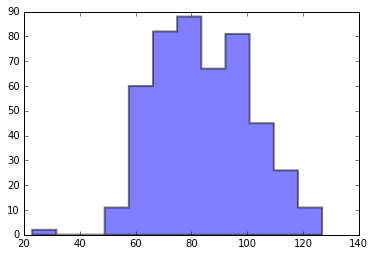

In [9]:
nbins = 12
bin_size = float(record_time)/ nbins

n_counts, bin_edges, _ = plt.hist(peak_times,nbins,normed=False,label='Popping Times',lw=2,\
                    histtype='stepfilled',alpha=0.5,color='b')


bins = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate Gaussian distribution
coeff, _ = curve_fit(gauss, bins, n_counts, p0=([1.,40.,5.]))
x_g = linspace(0,record_time,200)

# Calculate Poisson distribution
ave_time = cumsum(peak_times)[-1] / len(peak_times)
k = np.array(range(0,record_time))
fact = [ math.factorial(i) for i in k ]

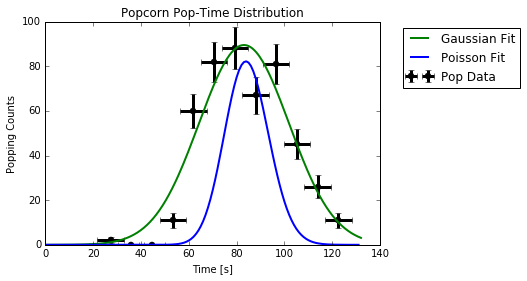

In [10]:
fig = plt.figure()
plt.errorbar(bins,n_counts,yerr=np.sqrt(n_counts),xerr=bin_size/2,fmt='o',color='k',lw=3,label='Pop Data')
plt.plot(x_g, gauss(x_g,*coeff), 'g-',label='Gaussian Fit',lw=2)
plt.plot(k,len(peak_times)*4*poiss(k,fact,ave_time),'b-',label='Poisson Fit',lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel("Popping Counts")
plt.xlabel("Time [s]")
plt.title("Popcorn Pop-Time Distribution")
plt.show()

# Distribution looks normal!
Statistical uncertanties: Gaussian fit looks good with a few discrepancies. We can potentially improve this fit by increasing sample size, choosing bin size more carefully. 

Systematic uncertainties: Sampling rate is quite high-- I don't think we miss any pops (even those that sound almost simaletaneous) due to aliasing. Microwave background baseline is much lower than pop amplitude, and unlikely to affect our measurements. 

Summary: I suspected this process did not follow a Poisson distribution because the popping rate depends on the time interval of observation. Nevertheless, this is a counting experiment so the idea was worth exploring. Poisson fit is not good.

Other possible scenarios: Popcorn popping follows a Boltzmann distribution. This is an appealing idea because the probability density function follows a similar shape, however a Boltzmann distribution requires the presence of constant temperature source or reservoir. Will not explore this idea further here.

Further question(s): Can we extract energy released in pop from the area under the pop pulse?